In [3]:
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
💻 Utilisation du device : cpu


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

# Vérifier si GPU est dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("💻 Utilisation du device :", device)

💻 Utilisation du device : cpu


In [13]:
transform = transforms.Compose([
    transforms.Resize ((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [19]:
#CHARGEMENT DES DONNÉES
dataset_path = "./brain_tumor_dataset"  # <-- remplace ce chemin
dataset = ImageFolder(root=dataset_path, transform=transform)

In [23]:
#Diviser jeu de donné 
train_size= int(0.8* len(dataset))
val_size= len (dataset)-train_size
train_dataset, val_dataset= random_split(dataset, [train_size, val_size])

In [27]:
#Preparons les data
train_loader= DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=16, shuffle= False)

In [29]:
# Vérifier quelques infos
print(f"Nombre total d'images : {len(dataset)}")
print(f"Entraînement : {len(train_dataset)} | Validation : {len(val_dataset)}")
print(f"Classes : {dataset.classes}")

Nombre total d'images : 253
Entraînement : 202 | Validation : 51
Classes : ['no', 'yes']


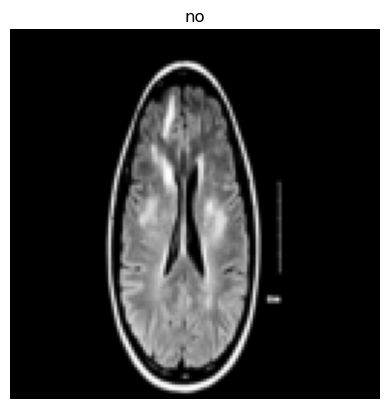

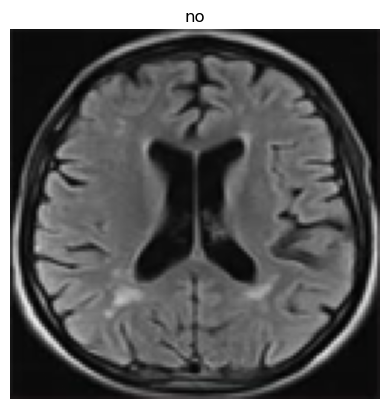

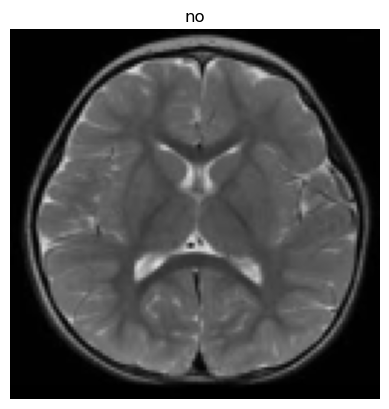

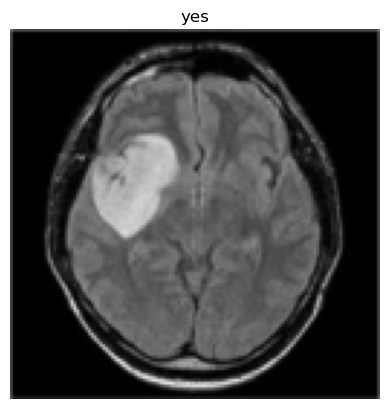

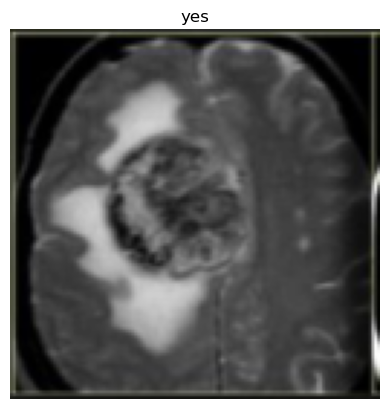

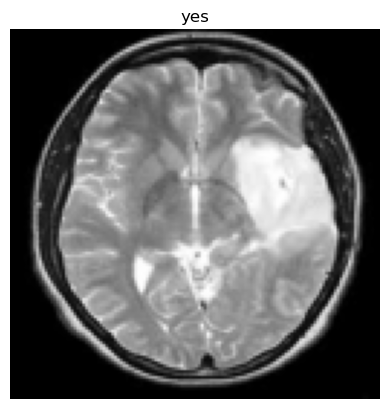

In [37]:
# Fonction utilitaire pour "dés-normaliser" une image et l'afficher
def imshow(img, label):
    img = img * 0.5 + 0.5  # annuler la normalisation (mean=0.5, std=0.5)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.title(label)
    plt.axis("off")
    plt.show()

# Dictionnaire pour traduire le label numérique en texte
class_names = dataset.classes  # ['no', 'yes']

# Récupérer un batch d'images du train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Afficher les 6 premières images du batch
for i in range(6):
    imshow(images[i], class_names[labels[i]]) 


Modele CNN

In [39]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # entrée = 3 canaux (RGB)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x128 → 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64 → 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 32x32 → 16x16
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # sortie : 2 classes (yes, no)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64 * 16 * 16)  # aplatissement
        x = self.fc_layers(x)
        return x


In [41]:
#Instancier le modèle
model = BrainTumorCNN().to(device)
print(model)

BrainTumorCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [43]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Nombre d’époques
num_epochs = 10

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1. Remise à zéro des gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Calcul de la perte
        loss = criterion(outputs, labels)

        # 4. Backward pass + mise à jour
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Afficher la perte moyenne par époque
    avg_loss = running_loss / len(train_loader)
    print(f"🔁 Époque {epoch+1}/{num_epochs} - 🔻 Perte : {avg_loss:.4f}")


🔁 Époque 1/10 - 🔻 Perte : 0.6946
🔁 Époque 2/10 - 🔻 Perte : 0.6232
🔁 Époque 3/10 - 🔻 Perte : 0.5237
🔁 Époque 4/10 - 🔻 Perte : 0.4567
🔁 Époque 5/10 - 🔻 Perte : 0.4142
🔁 Époque 6/10 - 🔻 Perte : 0.3671
🔁 Époque 7/10 - 🔻 Perte : 0.3444
🔁 Époque 8/10 - 🔻 Perte : 0.2687
🔁 Époque 9/10 - 🔻 Perte : 0.2610
🔁 Époque 10/10 - 🔻 Perte : 0.1831
